# Table of Contents
[1. Model Preparation](#1.-Model-Preperation)
<br>
* [1.1 Reviewing, Splitting data set](#1.1-Reviewing,-splitting-dataset-into-7:3-for-training-and-testing.)
* [1.2 Plotting features against target feature](#1.2-Plot-to-compare-all-features-to-target-feature-to-help-make-decisions-to-keep-for-the-models.)
    * [1.2.1 Plotting datetime feature against target feature](#Plotting-datetime-feature-against-target-feature)
    * [1.2.2 Plotting numerical features against target feature](#Plotting-numerical-features-against-target-feature)
    * [1.2.3 Plotting categorical features against target feature](#Plotting-categorical-features-against-target-feature)
* [1.3. Summary of all features](#1.3.-Summary-of-all-features)
    * [1.3.1 Numerical Features](#Numerical-Features)
    * [1.3.1 Cateogrical Features](#Categorical-Features)

Establishing a connection with sqlite database

In [1]:
# import pandas as pd
# import sqlite3

In [2]:
# # def function to create connection to db
# def create_connection(db_file):
#     """
#     create a database connection to the SQLite database specified by db_file
#     :param df_file: database file
#     :return: Connection object or None
#     """
#     conn = None
#     try: 
#         conn = sqlite3.connect(db_file)
#         return conn
#     except 'Error' as e:
#         print(e)
        
#     return conn

In [3]:
# # create connection to db
# conn = create_connection('s3://sagemaker-studio-520298385440-7in8n1t299/dublinbus.db')

In [4]:
# # initialise query
# query = """
# SELECT leavetimes.*
# FROM leavetimes 
# WHERE TRIPID in  
#     (SELECT TRIPID
#     FROM trips
#     WHERE LINEID = '46A');
# """

In [5]:
# # execute query and read into dataframe
# query_df = pd.read_sql(query, conn)

# 1. Model Preperation

In [6]:
# import boto3
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import statsmodels.api as sm

# from sagemaker import get_execution_role
from patsy import dmatrices
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from math import log
from statistics import stdev

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Connecting to s3
# role = get_execution_role()
# bucket='sagemaker-studio-520298385440-7in8n1t299'
# data_key = 'route_46a.feather'
# data_location = 's3://{}/{}'.format(bucket, data_key)

In [7]:
# Loading file
df = pd.read_feather('route_46a-Copy1.feather')

## 1.1 Reviewing, splitting dataset into 7:3 for training and testing.

In [8]:
df.head(5)

,level_0,index,DAYOFSERVICE,DAYOFWEEK,MONTHOFSERVICE,TRIPID,PROGRNUMBER,STOPPOINTID,VEHICLEID,PLANNEDTIME_ARR,ACTUALTIME_ARR,PLANNEDTIME_DEP,ACTUALTIME_DEP,DWELLTIME,PLANNEDTIME_TRAVEL,ACTUALTIME_TRAVEL,IS_HOLIDAY,IS_WEEKDAY
0,969,43824,2018-01-01,Monday,January,5955567,15,334,2868381,37920,37840,37920,37840,0,-48195,-48394,1,1
1,970,43825,2018-01-01,Monday,January,5955567,16,406,2868381,38117,37913,38117,37922,9,197,73,1,1
2,971,43826,2018-01-01,Monday,January,5955567,17,747,2868381,38226,37983,38226,37983,0,109,61,1,1
3,972,43827,2018-01-01,Monday,January,5955567,18,842,2868381,38326,38047,38326,38047,0,100,64,1,1
4,973,43828,2018-01-01,Monday,January,5955567,19,845,2868381,38391,38079,38391,38079,0,65,32,1,1


In [9]:
df.tail(5)

,level_0,index,DAYOFSERVICE,DAYOFWEEK,MONTHOFSERVICE,TRIPID,PROGRNUMBER,STOPPOINTID,VEHICLEID,PLANNEDTIME_ARR,ACTUALTIME_ARR,PLANNEDTIME_DEP,ACTUALTIME_DEP,DWELLTIME,PLANNEDTIME_TRAVEL,ACTUALTIME_TRAVEL,IS_HOLIDAY,IS_WEEKDAY
4347782,4346354,116750045,2018-12-31,Monday,December,8590439,5,811,2868385,69850,69740,69850,69801,61,47,59,0,1
4347783,4346355,116750046,2018-12-31,Monday,December,8590439,6,812,2868385,69874,69821,69874,69821,0,24,20,0,1
4347784,4346356,116750047,2018-12-31,Monday,December,8590439,7,813,2868385,69901,69842,69901,69871,29,27,21,0,1
4347785,4346357,116750048,2018-12-31,Monday,December,8590439,8,814,2868385,70007,69914,70007,69914,0,106,43,0,1
4347786,4346358,116750049,2018-12-31,Monday,December,8590439,9,81,2868385,70099,70057,70099,70083,26,92,143,0,1


In [10]:
# Missing values
df.isnull().sum()

level_0               0
index                 0
DAYOFSERVICE          0
DAYOFWEEK             0
MONTHOFSERVICE        0
TRIPID                0
PROGRNUMBER           0
STOPPOINTID           0
VEHICLEID             0
PLANNEDTIME_ARR       0
ACTUALTIME_ARR        0
PLANNEDTIME_DEP       0
ACTUALTIME_DEP        0
DWELLTIME             0
PLANNEDTIME_TRAVEL    0
ACTUALTIME_TRAVEL     0
IS_HOLIDAY            0
IS_WEEKDAY            0
dtype: int64

In [11]:
# Unique types for each feature
df.nunique()

level_0               4347787
index                 4347787
DAYOFSERVICE              360
DAYOFWEEK                   7
MONTHOFSERVICE             12
TRIPID                  23279
PROGRNUMBER                65
STOPPOINTID               126
VEHICLEID                 320
PLANNEDTIME_ARR         65347
ACTUALTIME_ARR          68077
PLANNEDTIME_DEP         65347
ACTUALTIME_DEP          68069
DWELLTIME                1278
PLANNEDTIME_TRAVEL       9586
ACTUALTIME_TRAVEL       13880
IS_HOLIDAY                  2
IS_WEEKDAY                  2
dtype: int64

In [12]:
# Datatypes and convert
df.dtypes

level_0                        int64
index                          int64
DAYOFSERVICE          datetime64[ns]
DAYOFWEEK                     object
MONTHOFSERVICE                object
TRIPID                        object
PROGRNUMBER                   object
STOPPOINTID                   object
VEHICLEID                     object
PLANNEDTIME_ARR                int64
ACTUALTIME_ARR                 int64
PLANNEDTIME_DEP                int64
ACTUALTIME_DEP                 int64
DWELLTIME                      int64
PLANNEDTIME_TRAVEL             int64
ACTUALTIME_TRAVEL              int64
IS_HOLIDAY                    object
IS_WEEKDAY                    object
dtype: object

In [13]:
# Rows and columns
df.shape

(4347787, 18)

**Review so far:**
<br>
There are no more missing values and the constant columns have been removed.
* Remove index.
* Investigate level_0.
* Convert the following to categorical: DAYOFWEEK, MONTHOFSERVICE, PROGRNUMBER, STOPPOINTID, VEHICLEID, IS_HOLIDAY, IS_WEEKDAY.
* We have data for most of the days of the year and for each month.


In [14]:
df = df.drop(['level_0', 'index'], axis=1)

In [15]:
# Sorting by trip then dayofservice
df = df.sort_values(by=['TRIPID', 'DAYOFSERVICE'])

In [16]:
# Creating features
categorical_features = ['DAYOFWEEK', 'MONTHOFSERVICE', 'PROGRNUMBER', 'STOPPOINTID', 
                       'IS_HOLIDAY', 'IS_WEEKDAY', 'TRIPID', 'VEHICLEID']

datetime_features = ['DAYOFSERVICE']

numerical_features = ['PLANNEDTIME_ARR', 'ACTUALTIME_ARR', 'PLANNEDTIME_DEP', 'ACTUALTIME_DEP',
                     'DWELLTIME', 'PLANNEDTIME_TRAVEL']

target_feat = 'ACTUALTIME_TRAVEL'

In [17]:
# Converting object to categorical
for column in categorical_features:
    df[column] = df[column].astype('category')

In [18]:
# Replacing PROGRNUMBER equal to 1 of ACTUALTIME_TRAVEL with 0
df.loc[df['PROGRNUMBER'] == '1', 'ACTUALTIME_TRAVEL'] = 0

In [19]:
df.loc[df['ACTUALTIME_TRAVEL'] < 0, 'ACTUALTIME_TRAVEL'] 

0         -48394
21475      -2670
35964      -1410
36007      -1072
50968      -3586
           ...  
4301676    -3717
4329721    -1683
4310034    -4154
4347585     -335
4302025    -3139
Name: ACTUALTIME_TRAVEL, Length: 2876, dtype: int64

In [20]:
# # Converting numerical to timedelta
# for column in numerical_features:
#     df[column] = df[column].apply(pd.to_timedelta, unit='s')

In [21]:
# df['ACTUALTIME_TRAVEL'] = df['ACTUALTIME_TRAVEL'].apply(pd.to_timedelta, unit='s')

In [22]:
df.dtypes

DAYOFSERVICE          datetime64[ns]
DAYOFWEEK                   category
MONTHOFSERVICE              category
TRIPID                      category
PROGRNUMBER                 category
STOPPOINTID                 category
VEHICLEID                   category
PLANNEDTIME_ARR                int64
ACTUALTIME_ARR                 int64
PLANNEDTIME_DEP                int64
ACTUALTIME_DEP                 int64
DWELLTIME                      int64
PLANNEDTIME_TRAVEL             int64
ACTUALTIME_TRAVEL              int64
IS_HOLIDAY                  category
IS_WEEKDAY                  category
dtype: object

<br><br>
Setting the target feature as _y and x_ as the remaining features in the dataframe. 
<br><br>

In [23]:
df = df.sample(frac=1).reset_index(drop=True)

In [24]:
df.head(20)

,DAYOFSERVICE,DAYOFWEEK,MONTHOFSERVICE,TRIPID,PROGRNUMBER,STOPPOINTID,VEHICLEID,PLANNEDTIME_ARR,ACTUALTIME_ARR,PLANNEDTIME_DEP,ACTUALTIME_DEP,DWELLTIME,PLANNEDTIME_TRAVEL,ACTUALTIME_TRAVEL,IS_HOLIDAY,IS_WEEKDAY
0,2018-10-03,Wednesday,October,7788127,52,795,1000278,56410,56591,56410,56605,14,42,35,0,1
1,2018-05-23,Wednesday,May,6783691,25,907,2693250,28436,28538,28436,28538,0,67,24,0,1
2,2018-12-05,Wednesday,December,8150251,59,2039,1000269,25645,25998,25645,25998,0,32,28,0,1
3,2018-08-24,Friday,August,7327504,43,909,2534856,74040,74075,74040,74075,0,44,32,0,1
4,2018-01-08,Monday,January,6099087,61,804,1000278,64065,63271,64065,63282,11,39,20,0,1
5,2018-02-20,Tuesday,February,6263657,53,2031,1000290,49720,50216,49720,50225,9,75,117,0,1
6,2018-05-10,Thursday,May,6745585,47,320,1932302,47087,47280,47087,47309,29,271,149,0,1
7,2018-03-22,Thursday,March,6397225,30,762,1932339,50034,49900,50034,49908,8,29,23,0,1
8,2018-05-04,Friday,May,6664078,17,747,2172280,69784,69983,69784,70006,23,155,168,0,1
9,2018-12-06,Thursday,December,8150259,29,761,1000305,69642,71331,69642,71331,0,45,28,0,1


In [25]:
# Creating y and x axis
target_feature = df['ACTUALTIME_TRAVEL']
y = pd.DataFrame(target_feature)
X = df.drop(['ACTUALTIME_TRAVEL'], axis=1)

# Splitting dataset for train and testing data by 70/30
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

# Printing shape of the new split data
print("The original range is: ",df.shape[0])
print("The training range (70%):\t rows 0 to", round(X_train.shape[0]))
print("The test range (30%): \t rows", round(X_train.shape[0]), "to", round(X_train.shape[0]) + X_test.shape[0])

The original range is:  4347787
The training range (70%):	 rows 0 to 3043450
The test range (30%): 	 rows 3043450 to 4347787


In [26]:
X_train.head(5)

,DAYOFSERVICE,DAYOFWEEK,MONTHOFSERVICE,TRIPID,PROGRNUMBER,STOPPOINTID,VEHICLEID,PLANNEDTIME_ARR,ACTUALTIME_ARR,PLANNEDTIME_DEP,ACTUALTIME_DEP,DWELLTIME,PLANNEDTIME_TRAVEL,IS_HOLIDAY,IS_WEEKDAY
2296641,2018-11-27,Tuesday,November,8141834,17,747,2172237,26555,26828,26555,26855,27,124,0,1
1261342,2018-12-29,Saturday,December,8576934,43,2015,2868386,38140,38257,38140,38257,0,62,0,0
2777787,2018-06-04,Monday,June,6862226,10,817,2693222,74236,74172,74236,74172,0,66,1,1
1107681,2018-10-13,Saturday,October,8025668,14,6059,2693223,50786,51472,50786,51545,73,129,0,0
2419838,2018-12-08,Saturday,December,8153891,5,811,2693222,26275,26349,26275,26370,21,33,0,0


## 1.2 Plot to compare all features to target feature to help make decisions to keep for the models.

#### Plotting datetime feature against target feature

In [27]:
# Plot datetime feature against target feature
X_train.DAYOFSERVICE = pd.to_numeric(X_train.DAYOFSERVICE)
df_temp = pd.concat([X_train['DAYOFSERVICE'], y_train], axis=1)
correlation_dt = df_temp[['DAYOFSERVICE', 'ACTUALTIME_TRAVEL']].corr(method='pearson')
correlation_dt

,DAYOFSERVICE,ACTUALTIME_TRAVEL
DAYOFSERVICE,1.000000,0.003201
ACTUALTIME_TRAVEL,0.003201,1.000000


<AxesSubplot:xlabel='DAYOFSERVICE', ylabel='ACTUALTIME_TRAVEL'>

<Figure size 432x288 with 0 Axes>

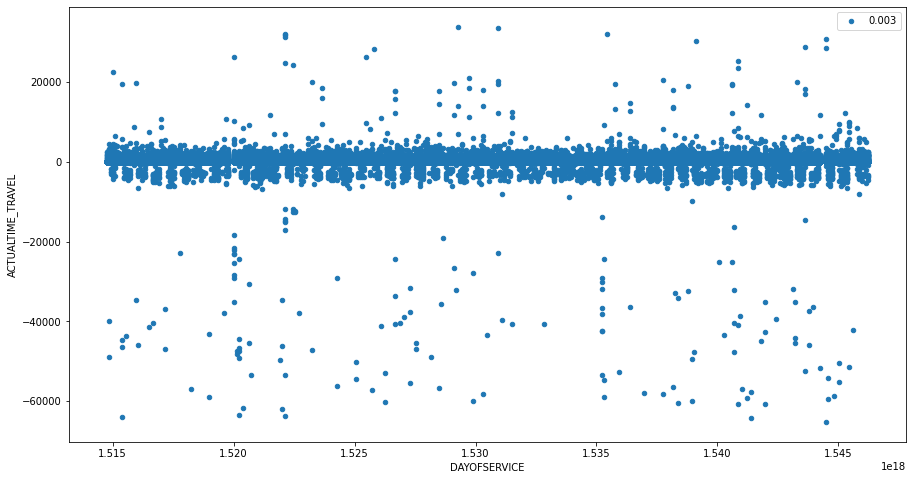

In [28]:
fig = plt.figure()
ax = fig.add_subplot
df_temp.plot(kind='scatter', x='DAYOFSERVICE', y='ACTUALTIME_TRAVEL', label = "%.3f" % df_temp[['ACTUALTIME_TRAVEL', 'DAYOFSERVICE']].corr().to_numpy()[0,1], figsize=(15, 8)) 

#### Plotting numerical features against target feature

In [29]:
# # Plot numerical features against target feature

# sns.set(style='white')

# # Calculating the correlation of all pairs of the numerical features
# corr = X_train[numerical_features].corr()

# # Generating a mask for the upper triangle
# mask = np.zeros_like(corr, dtype=np.bool)
# mask[np.triu_indices_from(mask)] = True

# # Set up matplotlib figure
# f, ax = plt.subplots(figsize=(20,20))

# # Generating a custome color map
# cmap = sns.diverging_palette(220, 10, as_cmap=True)

# # Draw the heatmap with the mask and correct aspect ratio
# sns.heatmap(corr, annot=True, mask=mask, cmap=cmap, vmax=1, vmin=-1,
#             square=True, xticklabels=True, yticklabels=True,
#             linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)
# plt.yticks(rotation = 0)
# plt.xticks(rotation = 90)

In [30]:
for column in numerical_features:
    df_temp = pd.concat([X_train[column], y_train], axis=1)
    correlation_dt = df_temp[[column, 'ACTUALTIME_TRAVEL']].corr(method='pearson')
    print('\n',correlation_dt)


                    PLANNEDTIME_ARR  ACTUALTIME_TRAVEL
PLANNEDTIME_ARR           1.000000           0.002547
ACTUALTIME_TRAVEL         0.002547           1.000000

                    ACTUALTIME_ARR  ACTUALTIME_TRAVEL
ACTUALTIME_ARR           1.000000           0.003352
ACTUALTIME_TRAVEL        0.003352           1.000000

                    PLANNEDTIME_DEP  ACTUALTIME_TRAVEL
PLANNEDTIME_DEP           1.000000           0.002547
ACTUALTIME_TRAVEL         0.002547           1.000000

                    ACTUALTIME_DEP  ACTUALTIME_TRAVEL
ACTUALTIME_DEP            1.00000            0.00342
ACTUALTIME_TRAVEL         0.00342            1.00000

                    DWELLTIME  ACTUALTIME_TRAVEL
DWELLTIME            1.00000            0.03626
ACTUALTIME_TRAVEL    0.03626            1.00000

                     PLANNEDTIME_TRAVEL  ACTUALTIME_TRAVEL
PLANNEDTIME_TRAVEL            1.000000           0.258613
ACTUALTIME_TRAVEL             0.258613           1.000000


Using pearson correlation, we see that the correlation between 

In [31]:
for column in numerical_features:
    df_temp = pd.concat([X_train[column], y_train], axis=1)
    correlation_dt = df_temp[[column, 'ACTUALTIME_TRAVEL']].corr(method='spearman')
    print('\n',correlation_dt)


                    PLANNEDTIME_ARR  ACTUALTIME_TRAVEL
PLANNEDTIME_ARR           1.000000          -0.052464
ACTUALTIME_TRAVEL        -0.052464           1.000000

                    ACTUALTIME_ARR  ACTUALTIME_TRAVEL
ACTUALTIME_ARR           1.000000          -0.050597
ACTUALTIME_TRAVEL       -0.050597           1.000000

                    PLANNEDTIME_DEP  ACTUALTIME_TRAVEL
PLANNEDTIME_DEP           1.000000          -0.052464
ACTUALTIME_TRAVEL        -0.052464           1.000000

                    ACTUALTIME_DEP  ACTUALTIME_TRAVEL
ACTUALTIME_DEP           1.000000          -0.050229
ACTUALTIME_TRAVEL       -0.050229           1.000000

                    DWELLTIME  ACTUALTIME_TRAVEL
DWELLTIME           1.000000           0.350084
ACTUALTIME_TRAVEL   0.350084           1.000000

                     PLANNEDTIME_TRAVEL  ACTUALTIME_TRAVEL
PLANNEDTIME_TRAVEL             1.00000            0.74916
ACTUALTIME_TRAVEL              0.74916            1.00000


<Figure size 432x288 with 0 Axes>

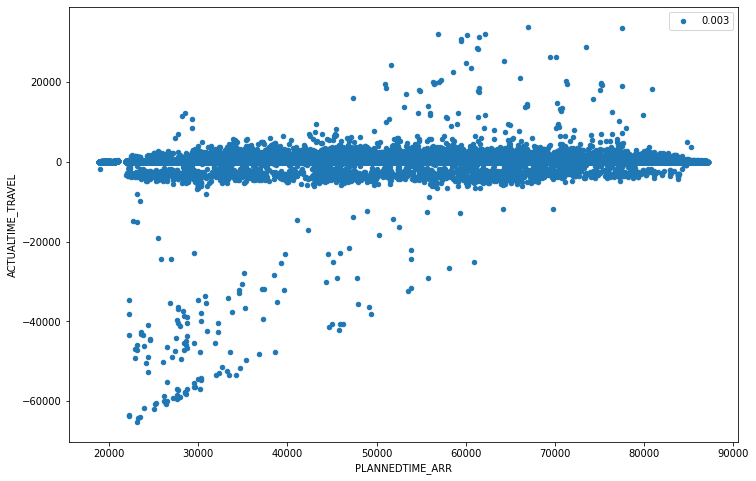

<Figure size 432x288 with 0 Axes>

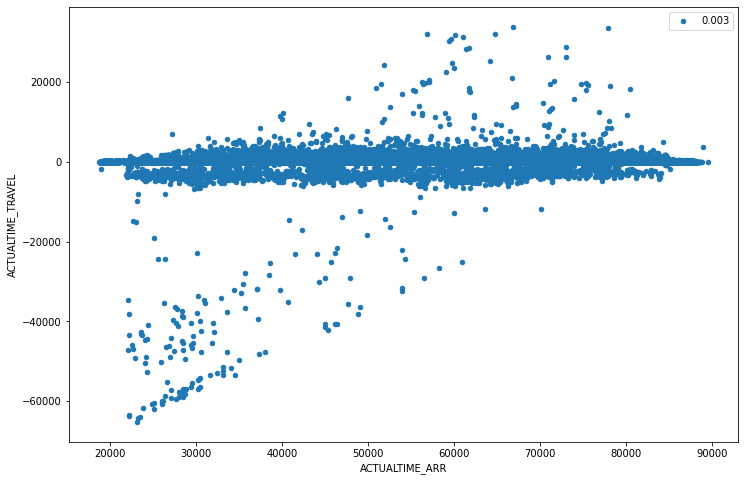

<Figure size 432x288 with 0 Axes>

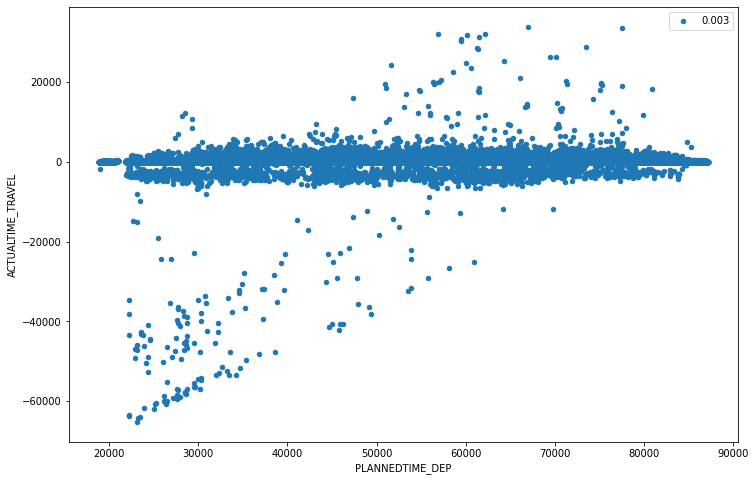

<Figure size 432x288 with 0 Axes>

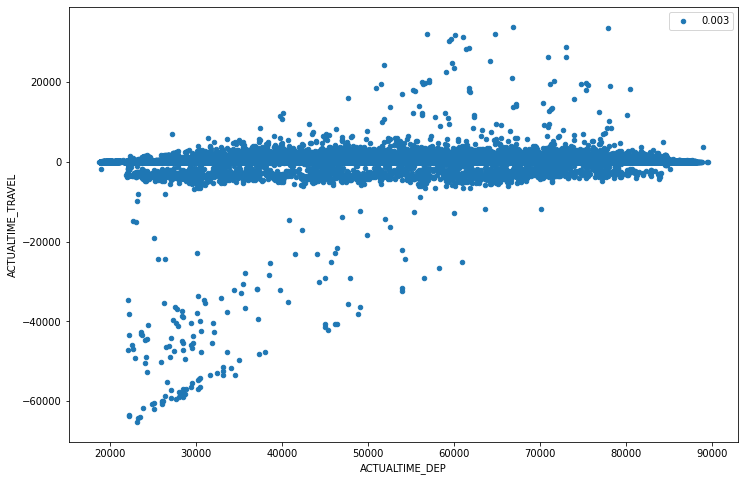

<Figure size 432x288 with 0 Axes>

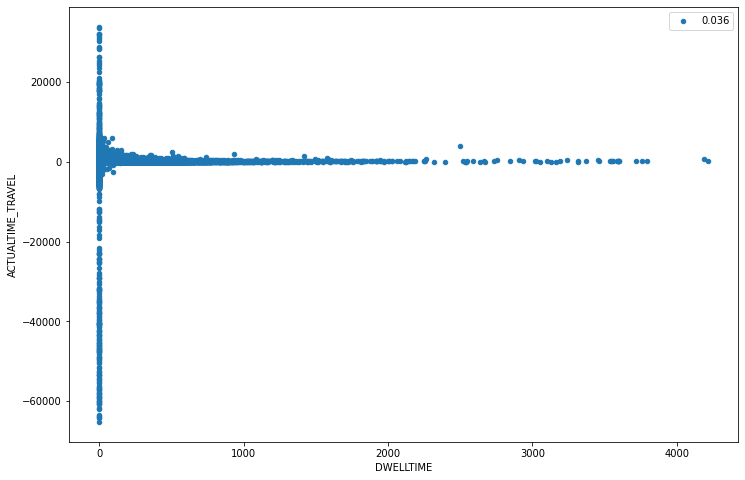

<Figure size 432x288 with 0 Axes>

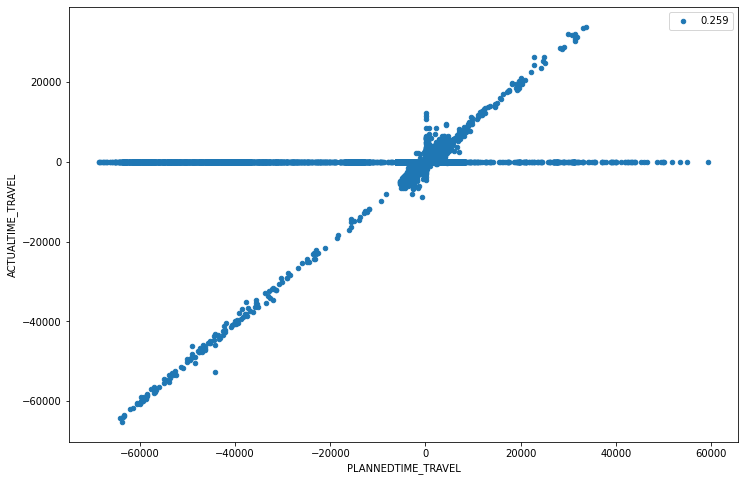

In [32]:
for column in numerical_features:
    df_temp = pd.concat([X_train[column], y_train], axis=1)
    fig = plt.figure()
    ax = fig.add_subplot
    df_temp.plot(kind='scatter', x=column, y='ACTUALTIME_TRAVEL', label = "%.3f" % df_temp[['ACTUALTIME_TRAVEL', column]].corr(method='pearson').to_numpy()[0,1], figsize=(12, 8)) 

<Figure size 432x288 with 0 Axes>

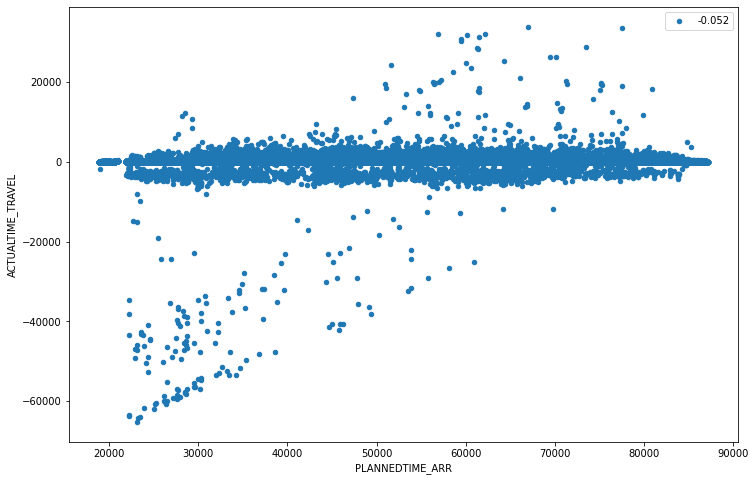

<Figure size 432x288 with 0 Axes>

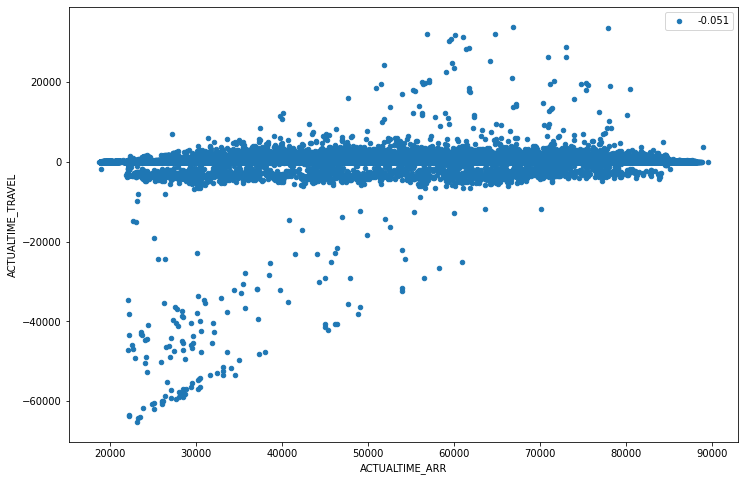

<Figure size 432x288 with 0 Axes>

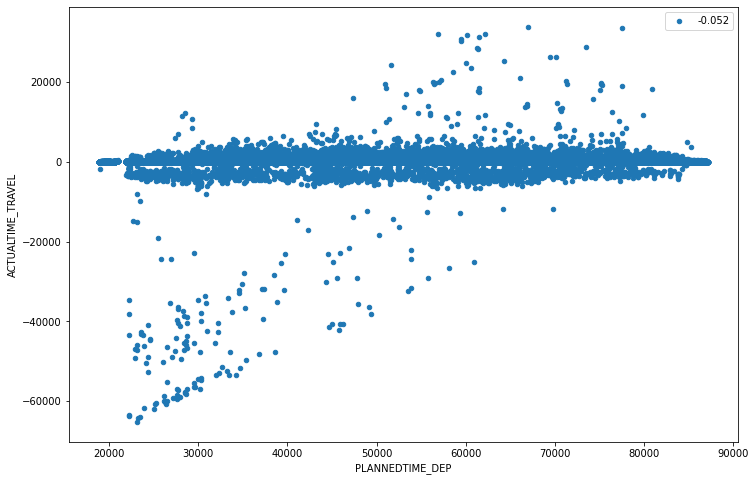

<Figure size 432x288 with 0 Axes>

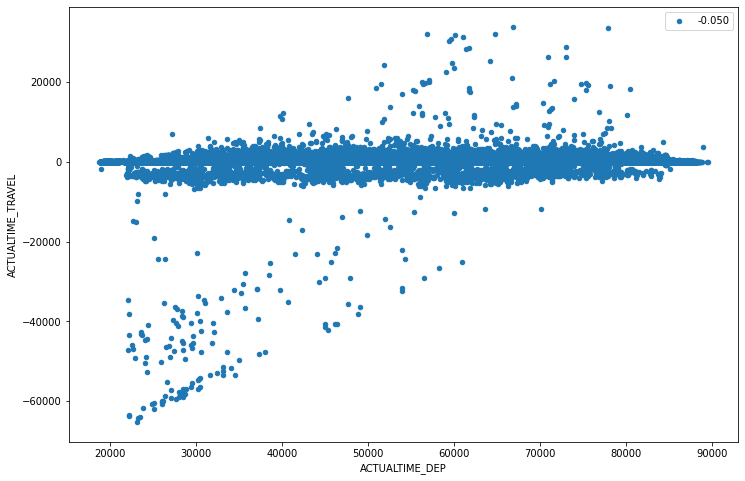

<Figure size 432x288 with 0 Axes>

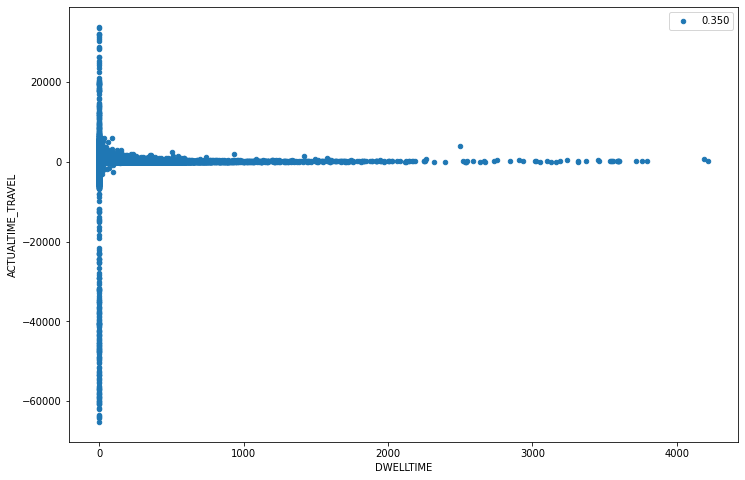

<Figure size 432x288 with 0 Axes>

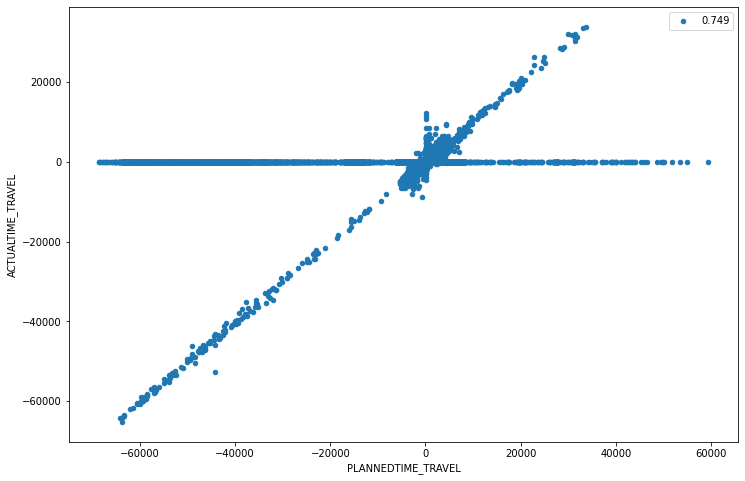

In [33]:
for column in numerical_features:
    df_temp = pd.concat([X_train[column], y_train], axis=1)
    fig = plt.figure()
    ax = fig.add_subplot
    df_temp.plot(kind='scatter', x=column, y='ACTUALTIME_TRAVEL', label = "%.3f" % df_temp[['ACTUALTIME_TRAVEL', column]].corr(method='spearman').to_numpy()[0,1], figsize=(12, 8)) 

In [34]:
df_numeric = df[numerical_features]
for feature in df_numeric:
    df_numeric[feature] = np.log(df_numeric[feature])
df_numeric['ACTUALTIME_TRAVEL'] = np.log(df['ACTUALTIME_TRAVEL'])

The original range is:  4347787
The training range (70%):	 rows 0 to 3043450
The test range (30%): 	 rows 3043450 to 4347787


<Figure size 432x288 with 0 Axes>

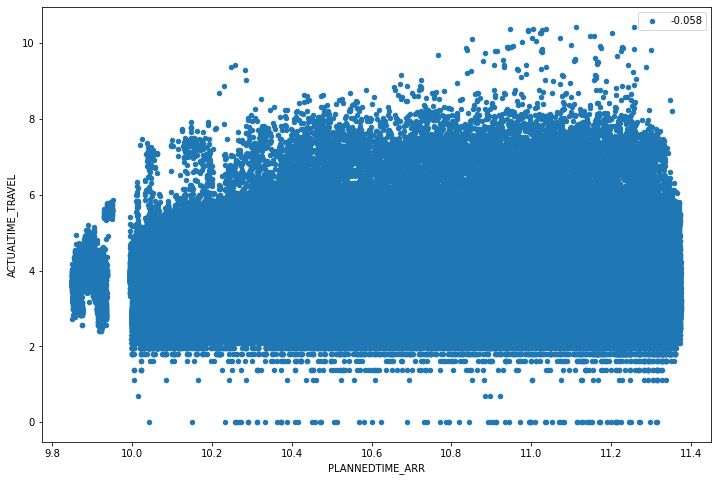

<Figure size 432x288 with 0 Axes>

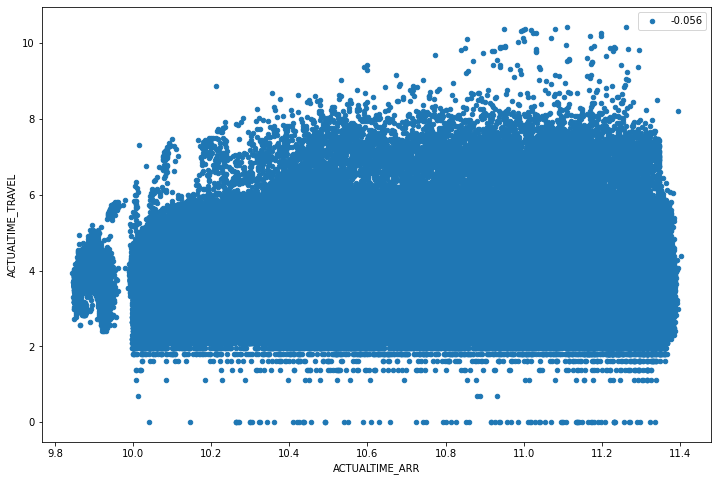

<Figure size 432x288 with 0 Axes>

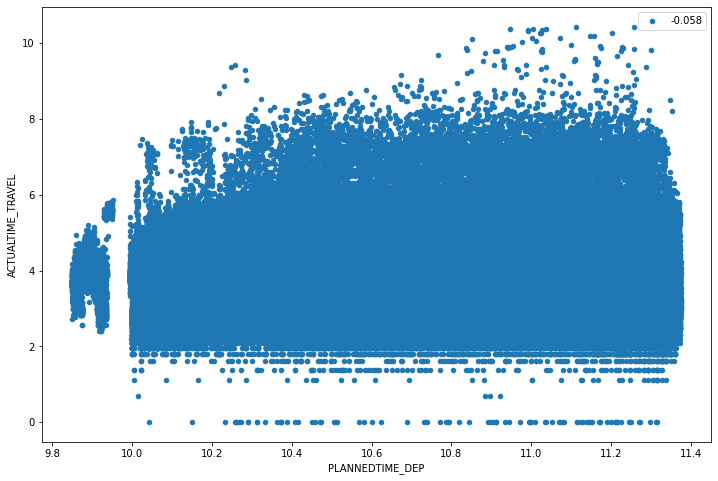

<Figure size 432x288 with 0 Axes>

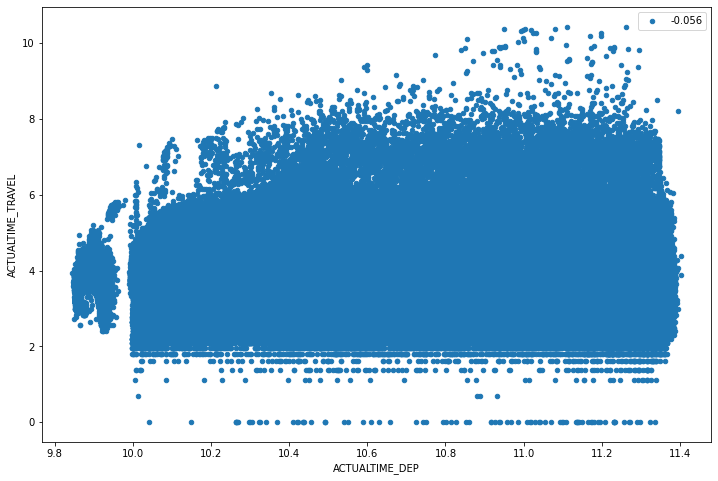

<Figure size 432x288 with 0 Axes>

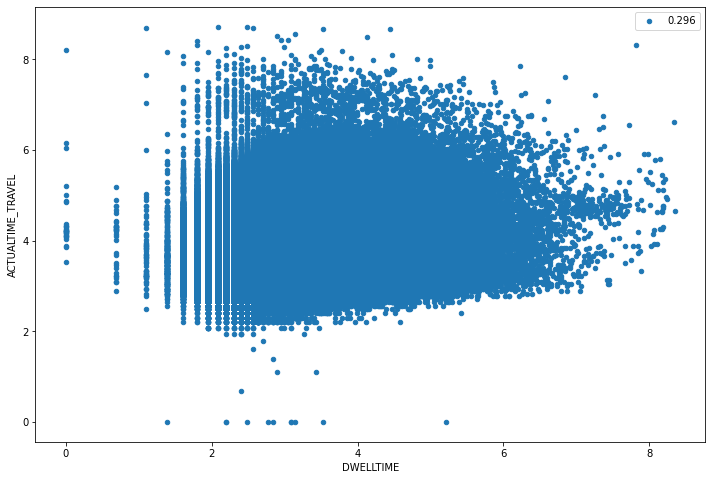

<Figure size 432x288 with 0 Axes>

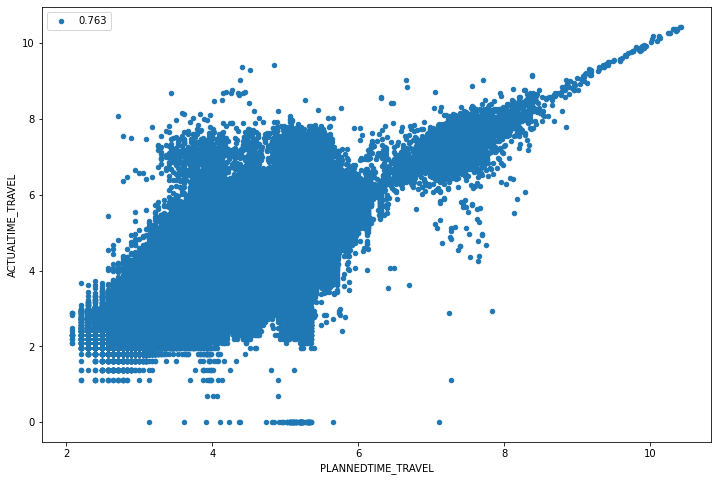

In [35]:
# Creating y and x axis
target_feature_numeric = df_numeric['ACTUALTIME_TRAVEL']
y_numeric = pd.DataFrame(target_feature_numeric)
X_numeric = df_numeric.drop(['ACTUALTIME_TRAVEL'], axis=1)

# Splitting dataset for train and testing data by 70/30
X_train_numeric, X_test_numeric, y_train_numeric, y_test_numeric = train_test_split(X_numeric, y_numeric, test_size=0.3, random_state=1)

# Printing shape of the new split data
print("The original range is: ",df.shape[0])
print("The training range (70%):\t rows 0 to", round(X_train_numeric.shape[0]))
print("The test range (30%): \t rows", round(X_train_numeric.shape[0]), "to", round(X_train_numeric.shape[0]) + X_test_numeric.shape[0])

for column in numerical_features:
    df_temp = pd.concat([X_train_numeric[column], y_train_numeric], axis=1)
    fig = plt.figure()
    ax = fig.add_subplot
    df_temp.plot(kind='scatter', x=column, y='ACTUALTIME_TRAVEL', label = "%.3f" % df_temp[['ACTUALTIME_TRAVEL', column]].corr(method='spearman').to_numpy()[0,1], figsize=(12, 8)) 

#### Plotting categorical features against target feature

DAYOFWEEK


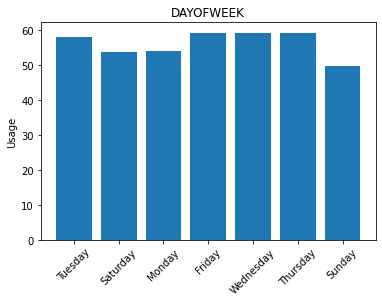

IS_HOLIDAY


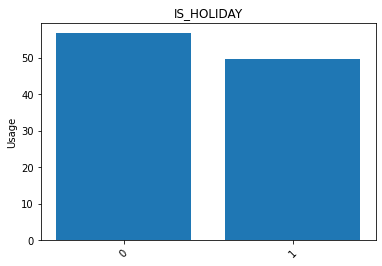

IS_WEEKDAY


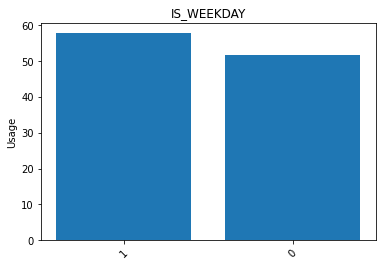

MONTHOFSERVICE


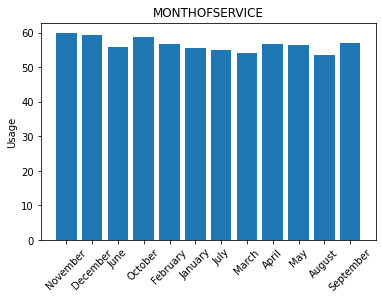

In [36]:
year_features = ['DAYOFWEEK', 'IS_HOLIDAY', 'IS_WEEKDAY', 'MONTHOFSERVICE']

for feature in year_features:
    print(feature)
    df_temp = pd.concat([X_train, y_train], axis=1)
    unique = df_temp[feature].unique()
    list_average = []
    
    for value in unique:
        list_values = df_temp[df_temp[feature]== value]['ACTUALTIME_TRAVEL'].tolist()
        length_list = len(list_values)
        average =  sum(list_values)/length_list
        list_average += [average]
#         print(f'Sum of values / list of values: \n {sum(list_values)} / {length_list}')
#         print(f'Average ACTUALTIME_TRAVEL: {average}, \n')
        
    # taken from https://pythonspot.com/matplotlib-bar-chart/
    y_pos = np.arange(len(unique))
    plt.bar(y_pos, list_average, align='center')
    plt.xticks(y_pos, unique)
    plt.ylabel('Usage')
    plt.title(feature)
    plt.xticks(rotation=45)

    plt.show()

I think there is some outliers in ACTUALTME_TRAVEL. The averages are all in negatives which suggests that the travel times. Would that be an outlier if the negative values are very great? 
<br><br>
**DAYOFWEEK:**
The lowest average is Sunday and the busiest is Monday. So it does make a difference.
<br><br>
**IS_WEEKDAY:**
The same comment that there is a difference in average times.
<br><br>
**MONTHOFSERVICE:**
Interestingly enough, they have difference averages depending on each month with August being the least busiest and April being the busiest. It must have something to do with the weather maybe?


In [37]:
# Average time for each vehicle id
df_temp = pd.concat([X_train, y_train], axis=1)
vehicleid = df_temp['VEHICLEID'].unique().tolist()
for id_ in vehicleid:
    print(f'VEHICLEID: {id_}')
    list_values = df_temp[df_temp['VEHICLEID']== id_]['ACTUALTIME_TRAVEL'].tolist()
    length_list = len(list_values)
    average =  sum(list_values)/length_list
    print(f'Average ACTUALTIME_TRAVEL: {average} \n')

VEHICLEID: 2172237
Average ACTUALTIME_TRAVEL: 58.957179363215694 

VEHICLEID: 2868386
Average ACTUALTIME_TRAVEL: 54.60460934946061 

VEHICLEID: 2693222
Average ACTUALTIME_TRAVEL: 48.505500184569954 

VEHICLEID: 2693223
Average ACTUALTIME_TRAVEL: 53.697737162750215 

VEHICLEID: 1000574
Average ACTUALTIME_TRAVEL: 57.09686626627817 

VEHICLEID: 1000586
Average ACTUALTIME_TRAVEL: 54.08287928017995 

VEHICLEID: 1000284
Average ACTUALTIME_TRAVEL: 56.92032101387462 

VEHICLEID: 1000296
Average ACTUALTIME_TRAVEL: 58.579505921901266 

VEHICLEID: 1000560
Average ACTUALTIME_TRAVEL: 57.23096564531105 

VEHICLEID: 2868331
Average ACTUALTIME_TRAVEL: 47.210403545602986 

VEHICLEID: 2534850
Average ACTUALTIME_TRAVEL: 55.1624649859944 

VEHICLEID: 1000556
Average ACTUALTIME_TRAVEL: 60.50671379487382 

VEHICLEID: 3370454
Average ACTUALTIME_TRAVEL: 51.65752032520325 

VEHICLEID: 2534806
Average ACTUALTIME_TRAVEL: 57.881278538812786 

VEHICLEID: 2534808
Average ACTUALTIME_TRAVEL: 53.51082598235766 

VEHIC

Average ACTUALTIME_TRAVEL: 57.206599175103115 

VEHICLEID: 2868381
Average ACTUALTIME_TRAVEL: 47.225987818210214 

VEHICLEID: 2172281
Average ACTUALTIME_TRAVEL: 57.039384706844025 

VEHICLEID: 2868326
Average ACTUALTIME_TRAVEL: 54.238653273809526 

VEHICLEID: 3265698
Average ACTUALTIME_TRAVEL: 54.82512539899681 

VEHICLEID: 2693278
Average ACTUALTIME_TRAVEL: 53.90871292617574 

VEHICLEID: 2693273
Average ACTUALTIME_TRAVEL: 53.19689227239545 

VEHICLEID: 2534810
Average ACTUALTIME_TRAVEL: 57.04543118511666 

VEHICLEID: 2693226
Average ACTUALTIME_TRAVEL: 49.82710027100271 

VEHICLEID: 2406887
Average ACTUALTIME_TRAVEL: 59.45123331070378 

VEHICLEID: 2406914
Average ACTUALTIME_TRAVEL: 62.51448516579406 

VEHICLEID: 2693217
Average ACTUALTIME_TRAVEL: 54.90565861843945 

VEHICLEID: 2534855
Average ACTUALTIME_TRAVEL: 58.42698747089478 

VEHICLEID: 2406866
Average ACTUALTIME_TRAVEL: 63.98084759576202 

VEHICLEID: 1932339
Average ACTUALTIME_TRAVEL: 59.17441572894769 

VEHICLEID: 2406896
Averag

Average ACTUALTIME_TRAVEL: 65.00854700854701 

VEHICLEID: 1932349
Average ACTUALTIME_TRAVEL: 86.34285714285714 

VEHICLEID: 1001191
Average ACTUALTIME_TRAVEL: 58.51020408163265 

VEHICLEID: 2693194
Average ACTUALTIME_TRAVEL: 55.84615384615385 

VEHICLEID: 2406913
Average ACTUALTIME_TRAVEL: 69.42857142857143 

VEHICLEID: 1000480
Average ACTUALTIME_TRAVEL: 57.526315789473685 

VEHICLEID: 1000268
Average ACTUALTIME_TRAVEL: 64.53846153846153 

VEHICLEID: 1001192
Average ACTUALTIME_TRAVEL: 75.0 

VEHICLEID: 1001162
Average ACTUALTIME_TRAVEL: 83.69565217391305 

VEHICLEID: 1000851
Average ACTUALTIME_TRAVEL: 55.0 

VEHICLEID: 2534825
Average ACTUALTIME_TRAVEL: 63.791666666666664 

VEHICLEID: 1001230
Average ACTUALTIME_TRAVEL: 71.41666666666667 

VEHICLEID: 1000943
Average ACTUALTIME_TRAVEL: -423.7307692307692 

VEHICLEID: 1932313
Average ACTUALTIME_TRAVEL: 78.14285714285714 

VEHICLEID: 3088377
Average ACTUALTIME_TRAVEL: 66.95833333333333 

VEHICLEID: 3088370
Average ACTUALTIME_TRAVEL: 61.291

In [38]:
# Making dummy variables for categorical 
cat = ['DAYOFWEEK', 'MONTHOFSERVICE', 'PROGRNUMBER', 'STOPPOINTID', 'IS_HOLIDAY', 'IS_WEEKDAY']
df_temp = pd.concat([X_train, y_train], axis=1)
df_copy = df_temp.copy()
df_copy = df_copy[cat]
df_copy = pd.get_dummies(df_copy)
df_copy = pd.concat([df_copy, y_train], axis=1)

categorical_corr = df_copy.corr()['ACTUALTIME_TRAVEL'][:]

In [39]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(categorical_corr)

DAYOFWEEK_Friday            0.003223
DAYOFWEEK_Monday           -0.003242
DAYOFWEEK_Saturday         -0.002992
DAYOFWEEK_Sunday           -0.006730
DAYOFWEEK_Thursday          0.003324
DAYOFWEEK_Tuesday           0.001701
DAYOFWEEK_Wednesday         0.003102
MONTHOFSERVICE_April        0.000198
MONTHOFSERVICE_August      -0.002659
MONTHOFSERVICE_December     0.002166
MONTHOFSERVICE_February     0.000082
MONTHOFSERVICE_January     -0.000864
MONTHOFSERVICE_July        -0.001410
MONTHOFSERVICE_June        -0.000623
MONTHOFSERVICE_March       -0.002125
MONTHOFSERVICE_May         -0.000084
MONTHOFSERVICE_November     0.003021
MONTHOFSERVICE_October      0.001870
MONTHOFSERVICE_September    0.000429
PROGRNUMBER_1              -0.021730
PROGRNUMBER_10             -0.004449
PROGRNUMBER_11             -0.014612
PROGRNUMBER_12             -0.006730
PROGRNUMBER_13              0.010449
PROGRNUMBER_14              0.005728
PROGRNUMBER_15              0.012940
PROGRNUMBER_16              0.023329
P

## 1.3. Summary of all features
<br><br>
#### Numerical Features
<br><br>

**DayOfService:**
* The correlation to the target feature is very low of 0.03806.
* Don't see it being a useful feature for the target feature. 
* Plot represents a straight line, which suggests little to no correlation.
* Conclusion: dropped because of the low correlation score. 

**PlannedTime_Arr:**
* There is very low correlation against the target feature though it gets better using spearman correlation.
* After logging the data, the correlation plot did not make a huge difference when using the spearman method to plot it for the second time. 
* Pearson and spearman plot pre log suggests little correlation as it is a continuous straight line. However, this shouldn't mean it should be dropped.
* When most values in the target feature fell less than 10, we see that the plannedtime arrival values increasing, it didn't change much. This would be due to the fact that the target feature is the difference between times so it would make sense that the relationship is poor.
* After logging the data, the plot is more spread out instead of a straight line, but the correlation score still shows a similar low score with a .02 difference using the spearman method. 
* Conclusion: However, this will not be dropped because having information about the planned time arrival can influence the target feature. 

**ActualTime_Arr:**
* Compared to Planned time arrival feature, the pearson correlation score is poorer but the spearman scores are more similar pre log. 
* It is similar to planned time arrival in that the plot represents a straight line, that suggests a poor relationship with the target feature. 
* After logging the data, it is found that the plot is more spread out. The score using spearman is not much different pre logging the data. 
* However, it would be unwise to drop this feature as it I feel it would serve good purpose for the target feature for predicting the prediction time for the next stop. 
* Conclusion: this will not be dropped.

**PlannedTime_Dep:**
* Planned time departure has little correlation with the target feature after looking at spearman and pearsons. 
* It doesn't have a linear relationship and the straight line on the plot of both methods proves this.
* However, when plotted using the logged values we see that the correlation score hasn't changed but the data is more spread out. 
* This doesn't change the relationship much, however. 
* Even so, this will be kept as I feel it would help the predictions. Having the planned time departures would help skew a better result because it would relatively be close to the actual time departure even though it is just an estimate.
* Conclusion: this will not be dropped as it will still serve to be a useful feature for predicting a time in seconds. 

**ActualTime_Dep:**
* Actual time departure is again, more or less the same. It represents the departure for these times at a particular stop to go to the next stop. It is strange that the correlation is so low even after logging the data but it would make sense as you wouldn't expect there to be a linear relationship.
* The plot is similar to the rest of the previous features mentioned so far. 
* However, it will still be kept because I feel it would still be a useful feature for predicting a time in seconds. 
* By taking the actual time departure for a particular stop it may help.
* Conclusion: this will not be dropped as it may prove to be useful.

**Dwell Time:**
* Dwell time has a 0.03 coorelation score with the target feature. It suggests on the graph that the time for dwell time equal to 0 then the more the target feature time increases. It might suggest traffic times where if a bus is full then it might be due to rush hour? busy hours?
* Plotting against the target feature after logging the data gives similar scores using the spearman correlation method. However we see the graph differing from pre log plot. It is more grouped up together compared to the previous graph plot.
* Because the score is more fairer compared to the previous, it will be useful to keep it for the modelling.
* Conclusion: Keep.

**PlannedTime_Travel:**
* When plotting using the pearse correlation method, it gave a correlation of 0.2. This time it is the highest correlation and we see a small linear relationship.
* The time for planned time travel, as it increases, so does the target feature. It gives us an indication of that slight linear relationship.
* Using spearmans to graph the correlation gave us a 0.7 score which is a good indication that the two features has a linear relationship.
* Because of this, this feature will be kept.

<br><br>
#### Categorical Features
<br><br>
**DayOfWeek:**
* In the graph we see the actual time travel increasing during weekdays and slowly the travel time is less during weekends. 
* This suggests a relationship between the days of the week and the target feature in which weekdays have a higher tendency for the actualtime travel feature to be higher.
* Conclusion: this will be kept.

**MonthofService:**
* In the graph, we don't really see a connection between each month against the target feature even if it is in order. 
* The overall actual travel time is higher in february before it dips, then rising during winter season.
* The correlation score seems to be poor also for each month. 
* This feature will still be kept. 

**Progrnumber:**
* Most progrnumbers will be dropped as a lot of the correlations are <0.00.
* For this reason, this feature will be dropped.
    
**StoppointID:**
* Similarly to progrnumbers, there are a lot of low correlations falling <0.00.
* Most stoppoint numbers are <0.00 correlation.
* This indicates a very low relationship with the target feature. 
* For this reason, this feature will be dropped.
    
**Is_Holiday:**
* After analyzing the graph, we see a relationship between the target feature and whether or not the time falls under a holiday date (non-school holiday).
* If it a non holiday, the actual time travel increases. 
* If it is a holiday, the actual time travel decreases. 
* This means that less people are using public transport if it is a holiday date.
* For this reason, this feature will be kept.

**Is_Weekday:**
* Like Is_Holiday, we see a relationship between the target feature and whether or not the time is during a weekday or not. 
* We see a contrast between the two values in which 1, being a weekday, has a higher actual time travel, vice versa.
* For this reason, it is a good indication of a relationship to the target feature.
* Therefore, this feature will be kept. 

**VehicleID:**
* When looking at the different averages, we see that the average differences are not big.
* For this reason, it may be best to drop this feature because it doesn't give any indication it would be a useful feature to help the prediction models.


## 1.4 Cleaning up features

### Setting low correlation features - keep

In [51]:
# Numerical features
low_corr_numerical = ['PLANNEDTIME_ARR', 'PLANNEDTIME_DEP', 'ACTUALTIME_ARR', 'ACTUALTIME_DEP']

# Categorical features
low_corr_categorical = ['DAYOFWEEK', 'MONTHOFSERVICE', 'IS_HOLIDAY', 'IS_WEEKDAY']

### Setting low correlation features - drop

In [55]:
low_corr = ['DAYOFSERVICE', 'VEHICLEID', 'TRIPID', 'STOPPOINTID', 'PROGRNUMBER']

### Setting high correlation  features

In [56]:
# Numerical features 
high_corr_numerical = ['DWELLTIME', 'PLANNEDTIME_TRAVEL']

### Dropping features & setting dummy features

In [57]:
df_copy = df.copy()
df_copy = df_copy.drop(low_corr, 1)

In [58]:
df_copy = pd.get_dummies(df_copy)
print(df_copy.columns.tolist())

['PLANNEDTIME_ARR', 'ACTUALTIME_ARR', 'PLANNEDTIME_DEP', 'ACTUALTIME_DEP', 'DWELLTIME', 'PLANNEDTIME_TRAVEL', 'ACTUALTIME_TRAVEL', 'DAYOFWEEK_Friday', 'DAYOFWEEK_Monday', 'DAYOFWEEK_Saturday', 'DAYOFWEEK_Sunday', 'DAYOFWEEK_Thursday', 'DAYOFWEEK_Tuesday', 'DAYOFWEEK_Wednesday', 'MONTHOFSERVICE_April', 'MONTHOFSERVICE_August', 'MONTHOFSERVICE_December', 'MONTHOFSERVICE_February', 'MONTHOFSERVICE_January', 'MONTHOFSERVICE_July', 'MONTHOFSERVICE_June', 'MONTHOFSERVICE_March', 'MONTHOFSERVICE_May', 'MONTHOFSERVICE_November', 'MONTHOFSERVICE_October', 'MONTHOFSERVICE_September', 'IS_HOLIDAY_0', 'IS_HOLIDAY_1', 'IS_WEEKDAY_0', 'IS_WEEKDAY_1']


### 

# 2. Linear Regression

In this section, I will be preparating a linear regression model. I will attempt to see the prediction overall. Then, I will attempt to input the weather data as well. 